<a href="https://colab.research.google.com/github/jewetta/AAE590DSMM/blob/main/Lecture_9_10Bayesian_Regression_ClassProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-9-306ae6f690dd>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_vals = np.arange(min(x), max(x), 0.1)


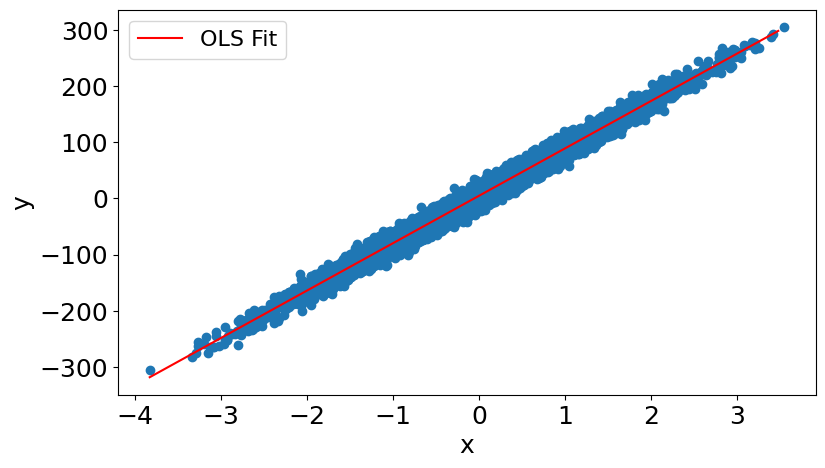

Output()

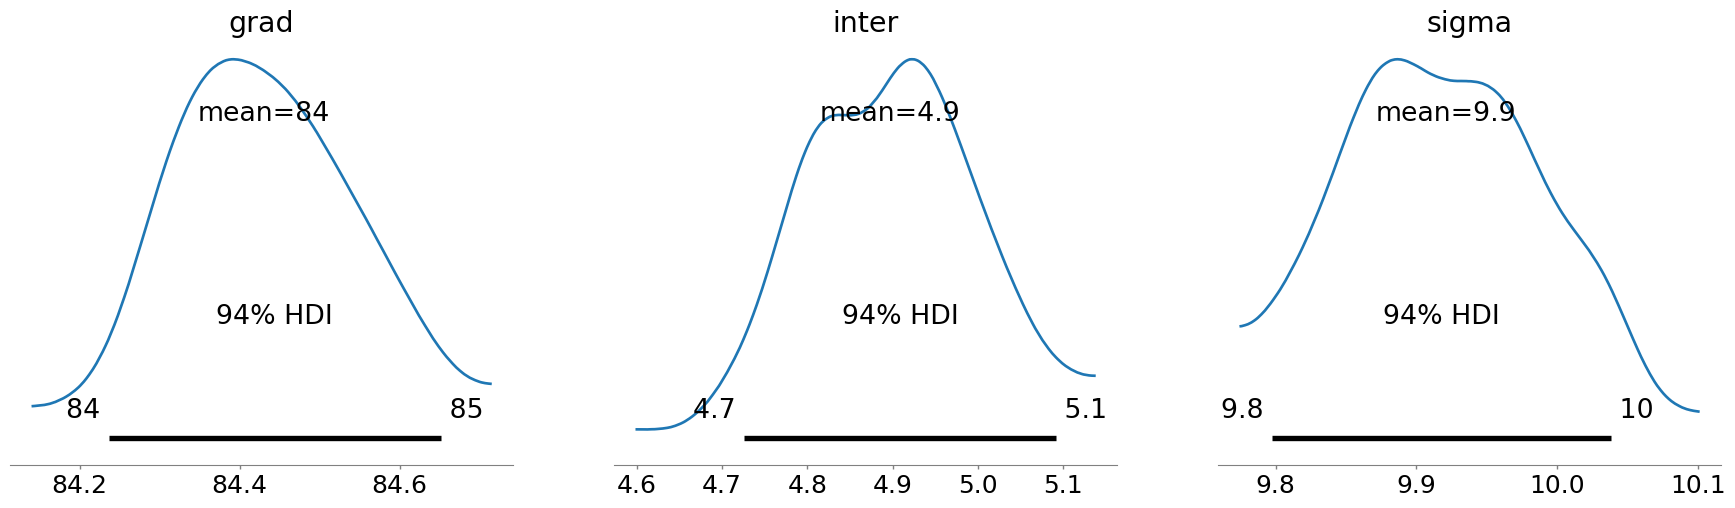

In [9]:
# Import pyMC3 and also arviz for visualisation
import pymc as pm
import arviz as az
# Import the other data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import norm
import statsmodels.formula.api as smf

# Generate data
x, y = datasets.make_regression(n_samples=10_000,
                                n_features=1,
                                noise=10,
                                bias=5)

# Create the dataframe
data = pd.DataFrame(list(zip(x.flatten(), y)),
               columns =['x', 'y'])
data

# OLS line
formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.params

# Get the residuals
results.resid.std()

# Get our equation of the OLS line
inter = results.params['Intercept']
slope = results.params['x']
x_vals = np.arange(min(x), max(x), 0.1)
ols_line = inter + slope * x_vals


# Plot the target against our feature with the OLS regression
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(data['x'], data['y'])
ax.plot(x_vals, ols_line,label='OLS Fit', color='red')
ax.ticklabel_format(style='plain')
plt.xlabel('x',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.savefig('pic.png')
plt.show()


# Start our model
with pm.Model() as model:

    # Define the priors on each parameter:
    grad = pm.Uniform("grad",
                      lower=results.params['x']*0.5,
                      upper=results.params['x']*1.5)

    inter = pm.Uniform("inter",
                       lower=results.params['Intercept']*0.5,
                       upper=results.params['Intercept']*1.5)

    sigma = pm.Uniform("sigma",
                       lower=results.resid.std()*0.5,\
                       upper=results.resid.std()*1.5)

    # Linear regression line
    mean = inter + grad*data['x']

    # Describe the distribution of our conditional output
    y = pm.Normal('y', mu=mean, sigma=sigma, observed=data['y'])


    # Run the sampling using pymc3 for 1000 samples
    trace_100 = pm.sample(100,return_inferencedata=True)

    with model:
      az.plot_posterior(trace_100,
                      var_names=['grad', 'inter', 'sigma'],
                      textsize=18,
                      point_estimate='mean',
                      rope_color='black')